In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# Generator
def create_generator():
    model = Sequential(name="Generator")
    n_nodes = 16 * 16 * 512
    model.add(Dense(n_nodes, input_shape=(100,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))
    return model


In [ ]:
# Discriminator
def create_discriminator():
    model = Sequential(name="Discriminator")
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))
    model.add(Flatten(name='Discriminator-Flatten-Layer'))
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout'))
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer'))
    return model

In [ ]:
# Define the generator and discriminator
generator = create_generator()
discriminator = create_discriminator()

In [ ]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (  (None, 131072)            13238272  
 Dense)                                                          
                                                                 
 Generator-Hidden-Layer-Res  (None, 16, 16, 512)       0         
 hape-1 (Reshape)                                                
                                                                 
 Generator-Hidden-Layer-2 (  (None, 32, 32, 256)       1179904   
 Conv2DTranspose)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 256)       0         
                                                                 
 Generator-Hidden-Layer-3 (  (None, 64, 64, 128)       295040    
 Conv2DTranspose)                                        

In [ ]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      896       
 -1 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      0         
 -Activation-1 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)        18496     
 -2 (Conv2D)                                                     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)      

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Define a seed for generating consistent results
seed = tf.random.normal([16, 100])

In [ ]:
def create_or_load_models():
    generator = create_generator()
    discriminator = create_discriminator()

    # Check if there are saved weights for generator and discriminator
    if os.path.exists("generator_weights.h5"):
        generator.load_weights("generator_weights.h5")
        print("Generator weights loaded.")
    if os.path.exists("discriminator_weights.h5"):
        discriminator.load_weights("discriminator_weights.h5")
        print("Discriminator weights loaded.")

    return generator, discriminator


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    predictions = (predictions + 1) / 2.0

    # Create the 'generated_images' directory if it doesn't exist
    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')

    # Plot the generated images
    fig, axes = plt.subplots(4,4, figsize=(4, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(predictions[i])
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_images/generated_image_epoch_{epoch}.png')
    plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import gc
class MemoryClearCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [ ]:

def train(dataset, start_epoch, epochs, batch_size):
    # Create or load the generator and discriminator models
    generator, discriminator = create_or_load_models()

    # Reduce batch size to manage memory usage
    batch_size = max(1, batch_size // 2)

    # Specify the path where you want to save the models
    checkpoint_path = "model_checkpoints/model_epoch_{epoch:02d}.h5"

    # Create a ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='auto',
        save_freq='epoch'
    )

    # Set up loss and optimizer
    cross_entropy = BinaryCrossentropy(from_logits=False)
    discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    # Compile the models
    generator.compile(loss=generator_loss, optimizer=generator_optimizer)
    discriminator.compile(loss=discriminator_loss, optimizer=discriminator_optimizer)

    # Instantiate the memory clear callback
    memory_clear_callback = MemoryClearCallback()

    # Training loop
    for epoch in range(start_epoch, epochs):
        print(f"Epoch {epoch}/{epochs}")

        # Variables to track losses
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        for real_images in dataset:
            noise = tf.random.normal([batch_size, 100])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            # Update average losses
            gen_loss_avg(gen_loss)
            disc_loss_avg(disc_loss)

        # Print average losses at the end of each epoch
        print(f"Generator Loss: {gen_loss_avg.result().numpy()}, Discriminator Loss: {disc_loss_avg.result().numpy()}")

        # Generate and save sample images at the end of each epoch
        if (epoch) % 10 == 0 or (epoch + 1) == epochs:
            generate_and_save_images(generator, epoch, seed)

        # Save models at checkpoints
        if (epoch) % 5 == 0:
            generator.save_weights('generator_weights.h5')
            discriminator.save_weights('discriminator_weights.h5')

        # Call memory clearing callback
        memory_clear_callback.on_epoch_end(epoch)

    # Print only the final losses
    print("Final Generator Loss:", gen_loss_avg.result().numpy())
    print("Final Discriminator Loss:", disc_loss_avg.result().numpy())


In [ ]:
# Example usage
batch_size = 64
s_epochs = 80
add=81
epochs=s_epochs+add
generator_losses = []
discriminator_losses = []
resized_dataset = tf.image.resize(combined_dataset, size=(256, 256))
# Assuming you have a combined_dataset variable with preprocessed images
train_dataset = tf.data.Dataset.from_tensor_slices(resized_dataset).shuffle(len(resized_dataset)).batch(batch_size)

# Train the model
train(train_dataset,s_epochs,  epochs, batch_size)

Generator weights loaded.
Discriminator weights loaded.
Epoch 147/180
Generator Loss: 4.196926593780518, Discriminator Loss: 0.3588504195213318
Epoch 148/180
Generator Loss: 4.288387298583984, Discriminator Loss: 0.5030791163444519
Epoch 149/180
Generator Loss: 4.362741947174072, Discriminator Loss: 0.5474995374679565
Epoch 150/180
Generator Loss: 4.136024475097656, Discriminator Loss: 0.45210808515548706


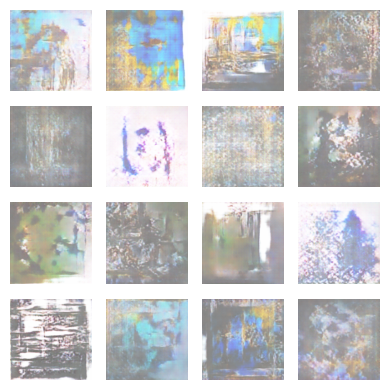

Epoch 151/180
Generator Loss: 4.462901592254639, Discriminator Loss: 0.16165460646152496
Epoch 152/180
Generator Loss: 4.625948429107666, Discriminator Loss: 0.41177457571029663
Epoch 153/180
Generator Loss: 4.611525058746338, Discriminator Loss: 0.2867918908596039
Epoch 154/180
Generator Loss: 4.8977131843566895, Discriminator Loss: 0.22963644564151764
Epoch 155/180
Generator Loss: 4.520965576171875, Discriminator Loss: 0.6815492510795593
Epoch 156/180
Generator Loss: 4.77191686630249, Discriminator Loss: 0.13555222749710083
Epoch 157/180
Generator Loss: 4.92997932434082, Discriminator Loss: 0.2842930257320404
Epoch 158/180
Generator Loss: 4.939291954040527, Discriminator Loss: 0.3540940284729004
Epoch 159/180
Generator Loss: 4.990876197814941, Discriminator Loss: 0.11996123194694519
Epoch 160/180
Generator Loss: 4.780816555023193, Discriminator Loss: 0.596968948841095


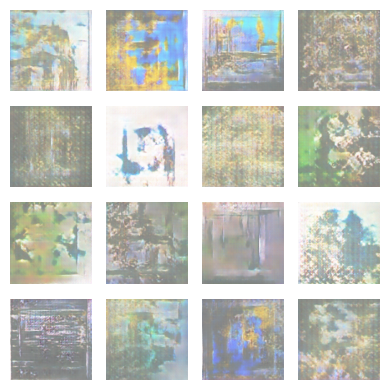

Epoch 161/180
Generator Loss: 4.972011566162109, Discriminator Loss: 0.12346551567316055
Epoch 162/180
Generator Loss: 5.291864395141602, Discriminator Loss: 0.07787598669528961
Epoch 163/180
Generator Loss: 5.141696453094482, Discriminator Loss: 0.6718969345092773
Epoch 164/180
Generator Loss: 5.236834526062012, Discriminator Loss: 0.15042239427566528
Epoch 165/180
Generator Loss: 5.119122505187988, Discriminator Loss: 0.6112998723983765
Epoch 166/180
Generator Loss: 4.681336879730225, Discriminator Loss: 0.4016272723674774
Epoch 167/180
Generator Loss: 4.871935844421387, Discriminator Loss: 0.1514091044664383
Epoch 168/180
Generator Loss: 4.9420342445373535, Discriminator Loss: 0.4628910720348358
Epoch 169/180
Generator Loss: 5.062878131866455, Discriminator Loss: 0.26731565594673157
Epoch 170/180
Generator Loss: 5.073054313659668, Discriminator Loss: 0.2033594399690628


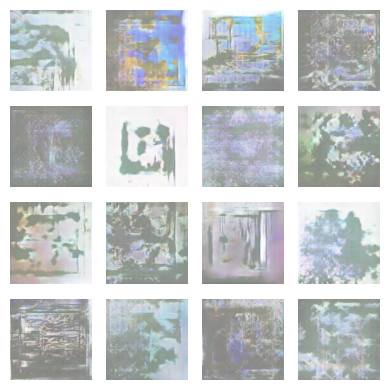

Epoch 171/180
Generator Loss: 5.368202209472656, Discriminator Loss: 0.49263137578964233
Epoch 172/180
Generator Loss: 5.371671199798584, Discriminator Loss: 0.2087286412715912
Epoch 173/180
Generator Loss: 5.042825222015381, Discriminator Loss: 0.3015793263912201
Epoch 174/180
Generator Loss: 4.972994804382324, Discriminator Loss: 0.3415372967720032
Epoch 175/180
Generator Loss: 5.1200361251831055, Discriminator Loss: 0.1816065013408661
Epoch 176/180
Generator Loss: 5.174994468688965, Discriminator Loss: 0.21606236696243286
Epoch 177/180
Generator Loss: 4.855893611907959, Discriminator Loss: 0.5826318860054016
Epoch 178/180
Generator Loss: 5.581295967102051, Discriminator Loss: 0.0821550264954567
Epoch 179/180
Generator Loss: 5.284635066986084, Discriminator Loss: 0.4748954176902771


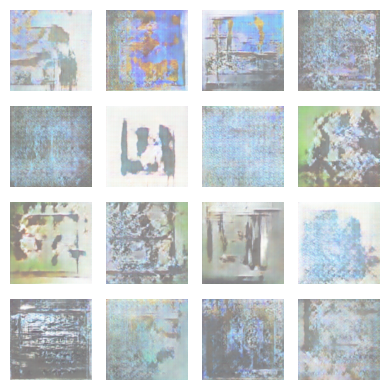

Final Generator Loss: 5.284635
Final Discriminator Loss: 0.47489542


In [ ]:
# Example usage
batch_size = 64
s_epochs = 147
add=33
epochs=s_epochs+add
generator_losses = []
discriminator_losses = []
resized_dataset = tf.image.resize(combined_dataset, size=(256, 256))
# Assuming you have a combined_dataset variable with preprocessed images
train_dataset = tf.data.Dataset.from_tensor_slices(resized_dataset).shuffle(len(resized_dataset)).batch(batch_size)

# Train the model
train(train_dataset,s_epochs,  epochs, batch_size)

Generator weights loaded.
Discriminator weights loaded.
Epoch 180/220
Generator Loss: 5.849892616271973, Discriminator Loss: 0.17227113246917725


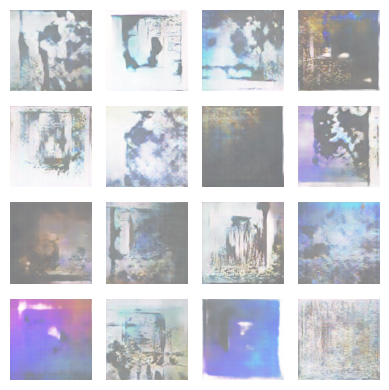

Epoch 181/220
Generator Loss: 6.296359062194824, Discriminator Loss: 0.41146841645240784
Epoch 182/220
Generator Loss: 5.70237922668457, Discriminator Loss: 0.13333825767040253
Epoch 183/220
Generator Loss: 6.023698329925537, Discriminator Loss: 0.1788286566734314
Epoch 184/220
Generator Loss: 5.317821502685547, Discriminator Loss: 0.14809323847293854
Epoch 185/220
Generator Loss: 5.800839424133301, Discriminator Loss: 0.42200392484664917
Epoch 186/220


In [ ]:
# Example usage
batch_size = 64
s_epochs = 180
add=40
epochs=s_epochs+add
generator_losses = []
discriminator_losses = []
resized_dataset = tf.image.resize(combined_dataset, size=(256, 256))
# Assuming you have a combined_dataset variable with preprocessed images
train_dataset = tf.data.Dataset.from_tensor_slices(resized_dataset).shuffle(len(resized_dataset)).batch(batch_size)

# Train the model
train(train_dataset,s_epochs,  epochs, batch_size)

In [ ]:
# Example usage
batch_size = 64
s_epochs = 185
add=35
epochs=s_epochs+add
generator_losses = []
discriminator_losses = []
resized_dataset = tf.image.resize(combined_dataset, size=(256, 256))
# Assuming you have a combined_dataset variable with preprocessed images
train_dataset = tf.data.Dataset.from_tensor_slices(resized_dataset).shuffle(len(resized_dataset)).batch(batch_size)

# Train the model
train(train_dataset,s_epochs,  epochs, batch_size)